In [1]:
#import all da nice stuff
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
import shutil

In [281]:
base_dir = os.getcwd() #"/mnt/c/JMA/Jan/projects/DMS_analysis"
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"
amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"
LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right=5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

# Functions

In [4]:
def r(x, y):
    return stats.spearmanr(x, y)

def correlation_plot(data, combination):
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(y=data[:,0], x=data[:,1], color='grey', ci=None, 
        scatter_kws={'alpha':.6, 'linewidth':0}, line_kws={"linewidth":0, 
        'label':f"Spearman's r: {round(r(data[~np.isnan(data).any(axis=1),:][:,0], data[~np.isnan(data).any(axis=1),:][:,1])[0], 2)}"})
    plt.xlabel('Log2 enrichment rep-1')
    plt.ylabe
    l('Log2 enrichment rep-2')
    plt.xlim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    plt.ylim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    sns.despine()
    g.tick_params(width=2)
    g.legend(frameon=False, loc='upper right')
    plt.title(f"{combination}", y=1.03)
    #plt.savefig(f"{fig_folder}/correlation_{combination}_{property}.svg")

def library_coverage(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    plt.figure(figsize=(5,5))
    ax = sns.heatmap(data=data, cmap='mako', cbar_kws={'label': f"Read counts"}, square=True, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

map = sns.diverging_palette(10, 260, s=100, l=30, as_cmap=True)
def mutation_enrichment(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    #center colorbar
    vcenter = 0
    vmin, vmax = data.min().min(), data.max().max()
    normalize = mcolors.TwoSlopeNorm(vcenter=0.01, vmin=0, vmax=0.1)

    plt.figure(figsize=(24,4))
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"counts"}, square=True, norm=normalize, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

def correlation_light_dark(dark, light, name, x_name='Light', y_name='Dark'):
    light_dark = pd.DataFrame(np.column_stack([dark.stack(dropna=False).to_list(),
                                    light.stack(dropna=False).to_list()]), columns=['Dark', 'Light'])
    stop_codons = pd.DataFrame(np.column_stack([dark.loc['*'].to_list(),
                                light.loc['*'].to_list()]), columns=['Dark', 'Light'])
    #light_dark = light_dark.iloc[1:-1,:]
    sns.set(font_scale = 1)
    sns.set_style("ticks", rc={'font.family':'sans-serif', 'font.sans-serif':'Droid Sans'})
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    ax = sns.scatterplot(data=light_dark, x='Light', y='Dark', color='grey', alpha=.4, linewidth=0, legend=False)
    ax1 = sns.scatterplot(data=stop_codons, x='Light', y='Dark', color='red', alpha=1, linewidth=0, legend=False)
    plt.xlabel(f"{x_name} log2 enriched read counts")
    plt.ylabel(f"{y_name} log2 enriched read counts")
    plt.xlim(light_dark.min().min()-1, light_dark.max().max() +1)
    plt.ylim(light_dark.min().min()-1, light_dark.max().max() +1)
    sns.despine()
    plt.axvline(0, 1,0, color='black', linewidth=2)
    plt.axhline(0, 1,0, color='black', linewidth=2)
    plt.title(f"{name} light vs dark")
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)



In [34]:
def find(string, value_list):
    indexes = [string.find(letter) for letter in value_list]
    try: 
        ind = min([index for index in indexes if index != -1])
    except:
        ind = 250
    return ind

def read_sequences(variant):
    """
    read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
    returns list of sequences
    """
    sequences = []
    a_sequences = []
    b_sequences = []
    y=0
    quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
    with open(f'{base_dir}/data/fastq/{variant}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{variant}_R2_001.fastq', "rt") as b_file:
        a_reader = QualityIO.FastqGeneralIterator(a_file)
        b_reader = QualityIO.FastqGeneralIterator(b_file)
        for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
                #if y < 10000:
                a_id, a_seq, a_qual = a
                b_id, b_seq, b_qual = b
                cutoff_a = find(a_qual, quality_score)
                cutoff_b = find(b_qual, quality_score)
                a_sequences.append(a_seq[:cutoff_a])
                b_sequences.append(b_seq[:cutoff_b])
                
                y+=1
                #else: 
                #    break
        print("total reads", total_read)
    return a_sequences, b_sequences

def gather_variants(a_seq, b_seq, DNA, insert_pos=0):
    """
    returns a dictionary with the counts of each amino acid at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(len(LOV)):
        mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                                                'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                                                'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                                                'W':0, 'Y':0, '*':0, 'wt':0}
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        counter +=1
        if counter%100000 == 0:
            print(counter)
        if catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            tr_a = translate_dna2aa(gene_a)
            for idx, pos in enumerate(tr_a):
                mutation_dict[idx][pos] += 1
        if dna_rev_comp(catch_right) in b_seq:
            index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
            gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
            tr_b = translate_dna2aa(gene_b)
            tr_b = tr_b[::-1]
            for idx, pos in enumerate(tr_b):
                mutation_dict[len(LOV)-idx-1][pos] += 1

    return mutation_dict


def gather_nt_variants(a_seq, b_seq, DNA, insert_pos=0):
    """
    returns a dictionary with the counts of each nt at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(gene_len):
        mutation_dict[idx] = {'A':0, 'T':0, 'G':0, 'C':0}

    for a_seq, b_seq in zip(a_seq, b_seq):
        #counter +=1
        #if counter%100000 == 0:
        #    print(counter)
        if catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            #tr_a = translate_dna2aa(gene_a)
            for idx, pos in enumerate(gene_a):
                mutation_dict[idx][pos] += 1
        if dna_rev_comp(catch_right) in b_seq:
            index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
            gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
            #tr_b = translate_dna2aa(gene_b)
            gene_b = gene_b[::-1]
            for idx, pos in enumerate(gene_b):
                mutation_dict[gene_len-idx-1][pos] += 1

    return mutation_dict


def process_reads(AA_sequence, DNA, variants = None):
    """
    process reads for given variants
    if variants = None, all variants stored in the fastq folder are processed
    """
    variants_dict = {}
    path = f'{base_dir}/data/fastq'
    filenames = glob.glob(f'{path}/*')

    if variants is not None: # filter filenames for given variants
        filenames = [path for path in filenames if any(variant in path for variant in variants)]

    for name in filenames: 
        if '_R1' in name:
            name = name.split('/')[-1].split('_R')[0]
            peptide_length = len(AA_sequence)
            length = len(AA_sequence) * 3
            flank_len = 10
            #process sequences
            sequences = []
            results = []
            f1 = name
            a_seq, b_seq = read_sequences(f1)
            variants_dict[name] = {}
            variants_dict[name]["AA"] = gather_variants(a_seq, b_seq, amplicon, DNA)
            variants_dict[name]["DNA"] = gather_nt_variants(a_seq, b_seq, amplicon, DNA)
            print(f'Done: {name}')

        # with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
        #     pkl.dump(variants_dict, handle)
    return variants_dict


# AraC analysis

In [382]:
#variants = process_reads( amplicon, amplicon_DNA)
DP6_variants = process_reads( amplicon, amplicon_DNA, variants = ['DP6'])
DP6_variants["DNA"] = pd.DataFrame.from_dict(DP6_variants['DP6']["DNA"])
DP6_variants["AA"] = pd.DataFrame.from_dict(DP6_variants['DP6']["AA"])



total reads 59258
Done: DP6


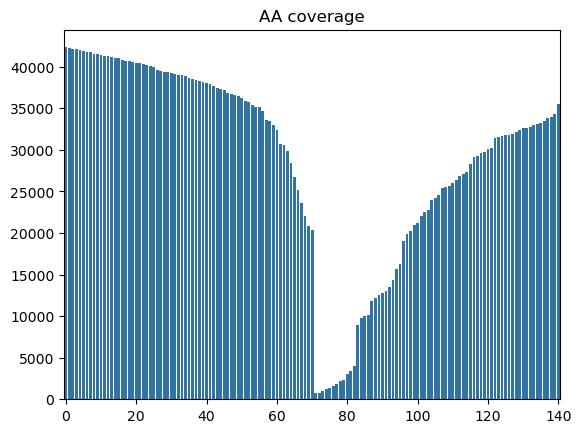

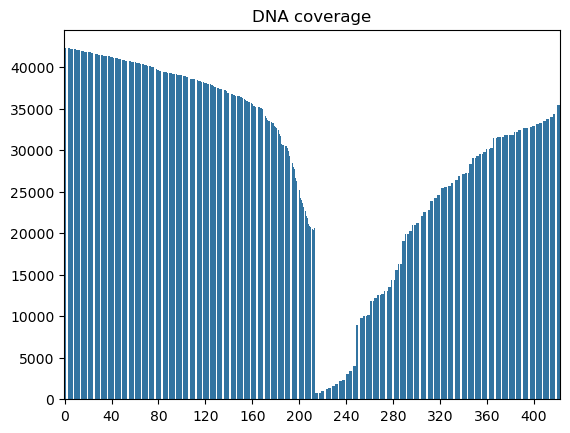

In [383]:
ax = sns.barplot(DP6_variants["AA"].sum())
plt.xticks(list(range(0,len(LOV),20)))
plt.title("AA coverage")
plt.show()
plt.clf

ax = sns.barplot(DP6_variants["DNA"].sum())
plt.xticks(list(range(0,gene_len,40)))
plt.title("DNA coverage")
plt.show()


### NOTE that the quality score cutoff is set to a 1 % error rate

In [390]:
coverage = DP6_variants['DNA'].sum().sum()/(DP6_variants['DNA'].max().max()*DP6_variants['DNA'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate = DP6_variants['AA'].max()/DP6_variants['AA'].sum()-1
mut_rate = abs(mut_rate.sum())
print(f'The mutation rate is estimated to be {mut_rate.round(1)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate/coverage*100,2)} AA mutations per sequence')

mut_rate = DP6_variants['DNA'].max()/DP6_variants['DNA'].sum()-1
mut_rate = abs(mut_rate.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate.round(1)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate/coverage*100,2)} DNA mutations per sequence')

The illumina paired reads cover on average 68.7 % of the LOV sequence
The mutation rate is estimated to be 1.6 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 2.27 AA mutations per sequence
The mutation rate is estimated to be 3.5 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 5.09 DNA mutations per sequence


In [270]:
def plot_mutation_enrichment(data, name, DNA = True):
    """
    If DNA = False, Amino acids are plotted
    non-mutated nucleotides/AAs (max count per col) are shown in grey (set to NA)
    input data should be a dataframe with the relative counts of each nucleotide/AA at each position
    name = plot title
    """
    #process data
    if DNA:
        Nt_order = ['A','C', 'G', 'T']
        data = data.loc[Nt_order]
    else: 
        AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
        data = data.loc[AA_order]

    #mask = data.isnull()
    # set max value = original Nt (AA) of each column to NA (as "true" nt)
    data = data.mask(data == data.max())

    #center colorbar
    #vcenter = 0
    #vmin, vmax = data.min().min(), data.max().max()
    #normalize = mcolors.TwoSlopeNorm(vcenter=0.02, vmin=0, vmax=0.04)

    plt.figure(figsize=(30,10))
    sns.reset_defaults()
    
    #sns.set(font_scale =5)
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"relative counts"})#, mask=mask)
    plt.title(name, fontsize=20)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=15)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.set_facecolor('gray')
    ax.grid(False)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

423


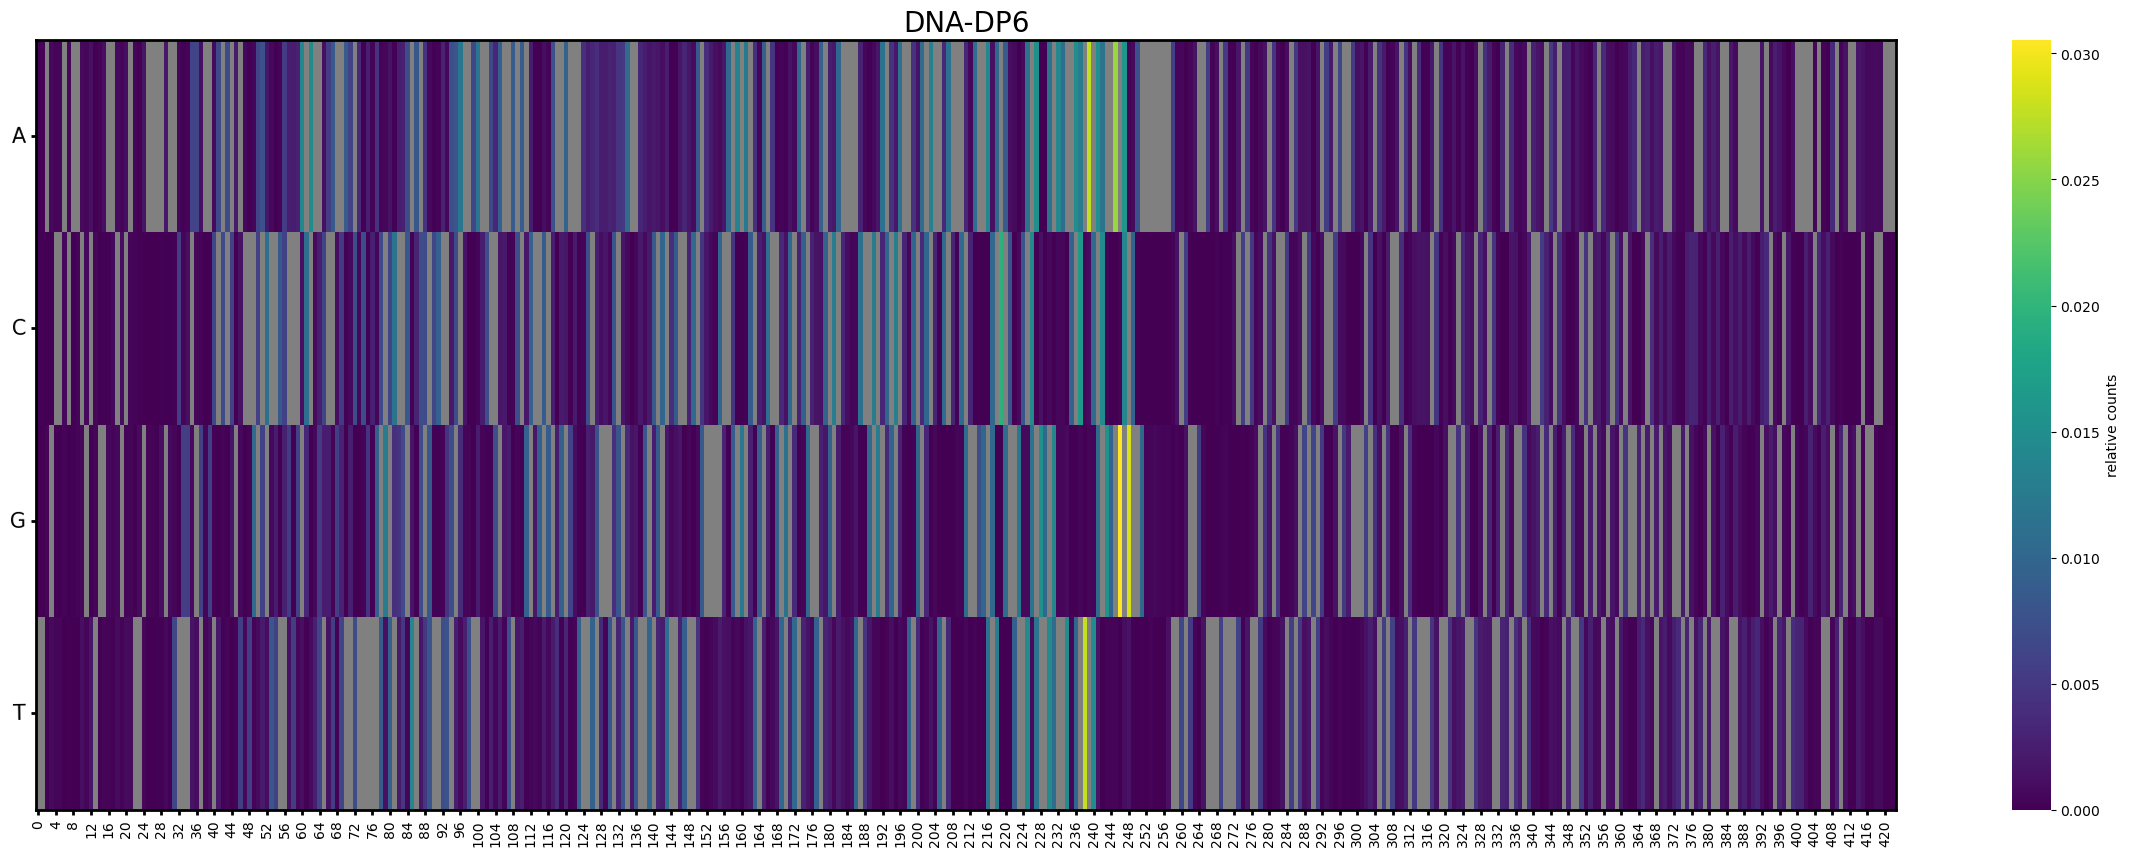

141


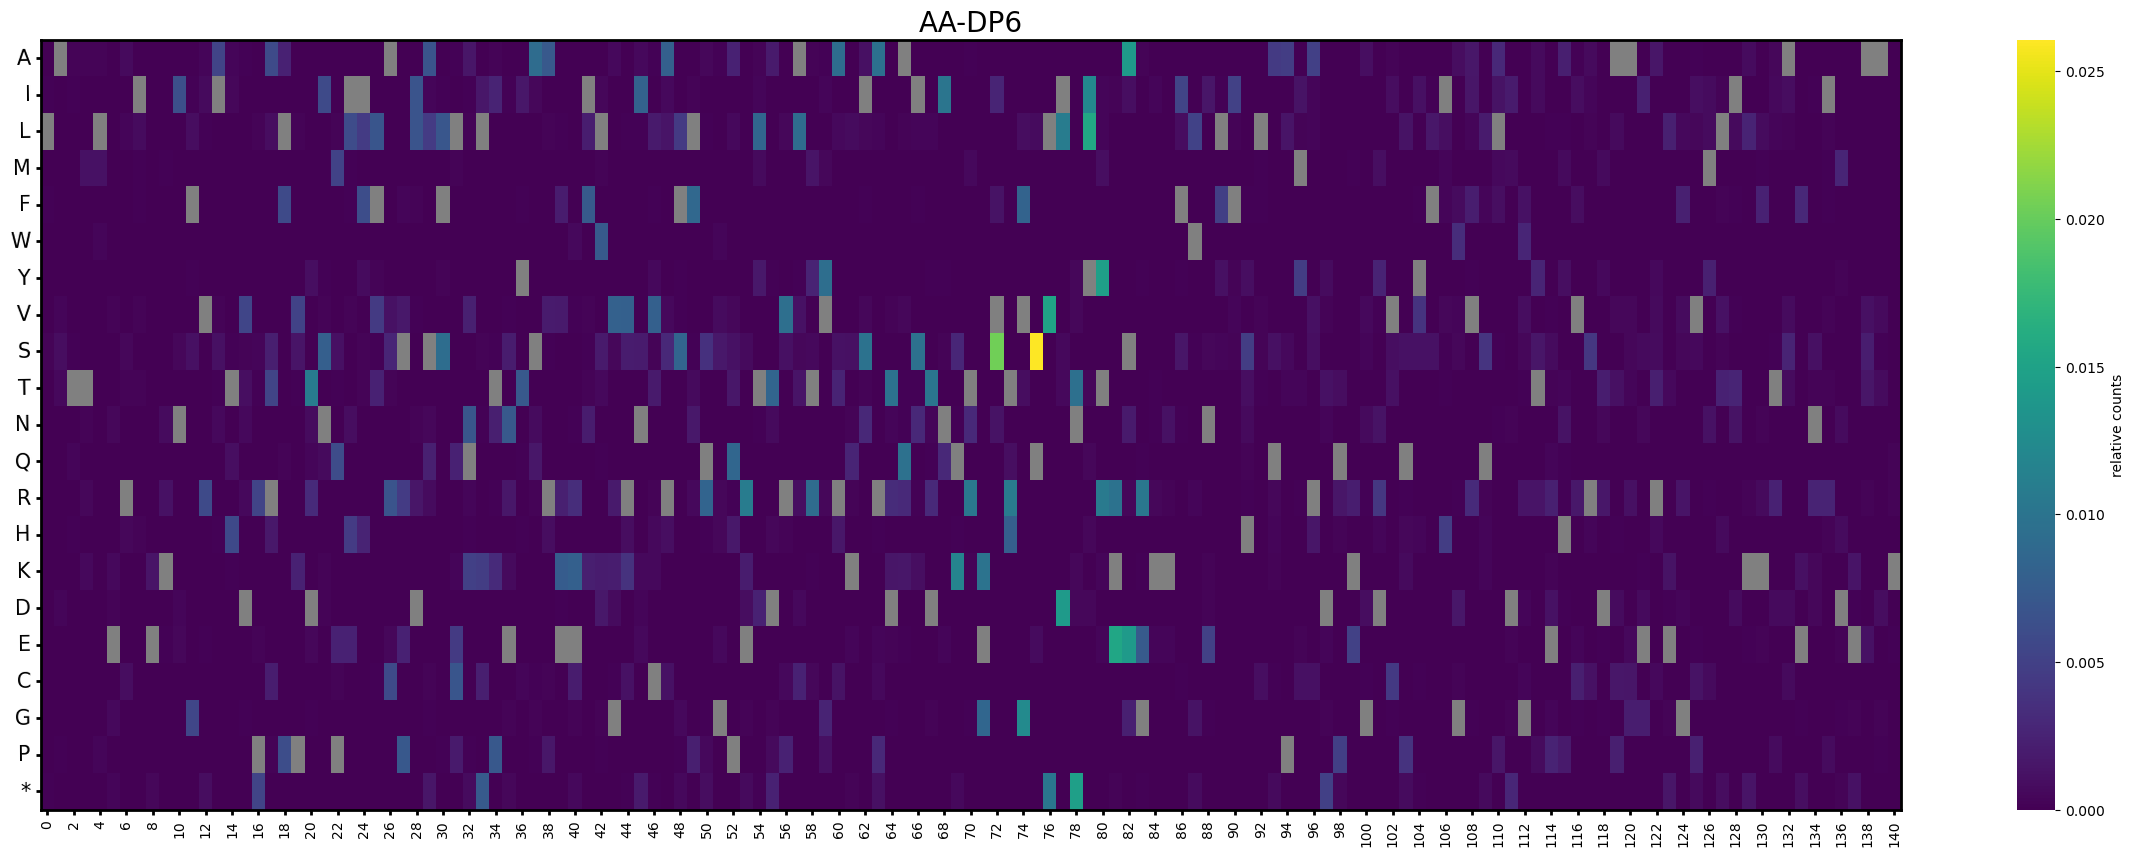

In [272]:
DNA_relative = DP6_variants['DNA']/DP6_variants['DNA'].sum()
plot_mutation_enrichment(DNA_relative, 'DNA-DP6')

AA_relative = DP6_variants['AA']/DP6_variants['AA'].sum()
plot_mutation_enrichment(AA_relative, 'AA-DP6', DNA = False)


In [290]:
DP6_variants.keys()

dict_keys(['DP6', 'DNA', 'AA'])

In [345]:
### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])
            #print("sum", n_muts_a_seq)
        else: n_muts_a_seq = 0
            
                
        if dna_rev_comp(catch_right) in b_seq:
            index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
            gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
            gene_b = gene_b[::-1]
            n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
            #print("sum", n_muts_b_seq)
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq
        
        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


In [392]:
DP6_a_seq, DP6_b_seq = read_sequences("DP6")
DP6_n_mutations = gather_n_mutations(DP6_a_seq, DP6_b_seq, reference_seq = LOV_gene)
## sort dictionary after key
DP6_n_mutations = dict(sorted(DP6_n_mutations.items()))
print(DP6_n_mutations)

total reads 59258
{0: 24164, 1: 27246, 2: 5696, 3: 696, 4: 89, 5: 33, 6: 11, 7: 10, 8: 10, 9: 9, 10: 12, 11: 4, 12: 8, 13: 11, 14: 8, 15: 9, 16: 7, 17: 7, 18: 6, 19: 3, 20: 5, 21: 9, 22: 15, 23: 14, 24: 11, 25: 6, 26: 5, 27: 5, 28: 7, 29: 13, 30: 17, 31: 8, 32: 11, 33: 33, 34: 7, 35: 7, 36: 5, 37: 33, 38: 21, 39: 11, 40: 4, 41: 9, 42: 12, 43: 14, 44: 22, 45: 5, 46: 10, 47: 6, 48: 18, 49: 10, 50: 8, 51: 14, 52: 13, 53: 6, 54: 14, 55: 12, 56: 13, 57: 55, 58: 67, 59: 60, 60: 10, 61: 8, 62: 22, 63: 15, 64: 6, 65: 14, 66: 6, 67: 25, 68: 5, 69: 68, 70: 24, 71: 5, 72: 6, 73: 9, 74: 8, 75: 8, 76: 2, 77: 4, 78: 6, 79: 11, 80: 6, 81: 3, 82: 2, 83: 2, 84: 2, 85: 5, 86: 5, 87: 3, 88: 2, 89: 4, 90: 4, 91: 9, 92: 4, 93: 4, 94: 5, 95: 3, 96: 6, 97: 8, 98: 4, 99: 3, 100: 4, 101: 5, 102: 11, 103: 15, 104: 5, 105: 6, 106: 9, 107: 11, 108: 2, 109: 2, 111: 1, 112: 7, 113: 12, 114: 6, 115: 2, 116: 2, 117: 3, 118: 13, 119: 69, 120: 13, 121: 1, 123: 1, 124: 2, 125: 2, 126: 2, 127: 3, 128: 2, 129: 1, 130: 4, 

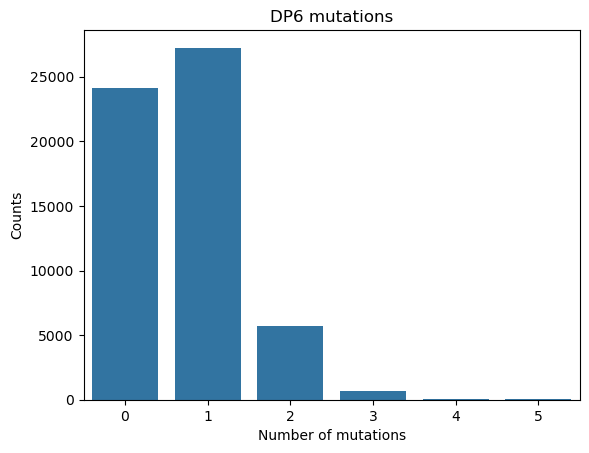

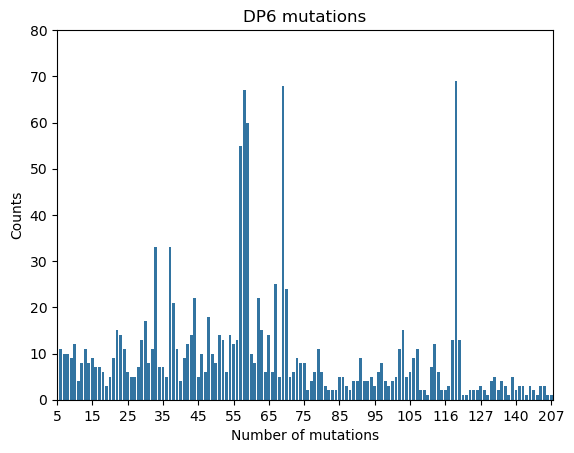

In [404]:
## plot number of mutations
sns.barplot(DP6_n_mutations)
plt.xlim(-0.5,5.5)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title('DP6 mutations')
plt.show()

plt.clf()
sns.barplot(DP6_n_mutations)
plt.xlim(5)
plt.xticks(list(range(5, 150, 10)))
plt.ylim(0,80)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title('DP6 mutations')
plt.show()

In [405]:
# calculate the mutation rate (!! different to before, here, we calculate the mutation rate per read, not per nt (i.e. we divide by the number of total reads, not the reads for each nt respectively!! --> perhaps inaccurate due to low coverage of some nts)
total_reads = sum(DP6_n_mutations.values())
total_mutations = sum([key*value for key, value in DP6_n_mutations.items()])
mutation_rate = total_mutations/total_reads
print(mutation_rate)

2.127052430854385


In [427]:
### calculate the mutagenic spectrum

def mut_spectrum(a_seq, b_seq, reference_seq):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'T':0, 'G':0, 'C':0},
                'T': {'A':0, 'T':0, 'G':0, 'C':0},
                'G': {'A':0, 'T':0, 'G':0, 'C':0},
                'C': {'A':0, 'T':0, 'G':0, 'C':0}}
    
    catch_length = len(catch_left)
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            for idx, nt in enumerate(gene_a): 
                if reference_seq[idx] != nt:
                    mut_spec[reference_seq[idx]][nt] += 1
            
                
        if dna_rev_comp(catch_right) in b_seq:
            index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
            gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
            gene_b = gene_b[::-1]
            for idx, nt in enumerate(gene_b):
                if reference_seq[::-1][idx] != nt:
                    mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

In [428]:
#DP6_a_seq, DP6_b_seq = read_sequences("DP6")
DP6_n_mut_spectrum, DP6_n_mut_spectrum_perc  = mut_spectrum(DP6_a_seq, DP6_b_seq, reference_seq = LOV_gene)

print(DP6_n_mut_spectrum)
print(DP6_n_mut_spectrum_perc)

{'A': {'A': 0, 'T': 7086, 'G': 6484, 'C': 7799}, 'T': {'A': 7133, 'T': 0, 'G': 5839, 'C': 8016}, 'G': {'A': 42966, 'T': 6437, 'G': 0, 'C': 8076}, 'C': {'A': 8997, 'T': 7950, 'G': 9264, 'C': 0}}
{'A': {'A': 0.0, 'T': 5.622, 'G': 5.144, 'C': 6.187}, 'T': {'A': 5.659, 'T': 0.0, 'G': 4.632, 'C': 6.36}, 'G': {'A': 34.087, 'T': 5.107, 'G': 0.0, 'C': 6.407}, 'C': {'A': 7.138, 'T': 6.307, 'G': 7.35, 'C': 0.0}}


In [480]:
DP6_n_mut_spectrum_perc_df = pd.DataFrame.from_dict(DP6_n_mut_spectrum_perc, orient='index')
DP6_n_mut_spectrum_df = pd.DataFrame.from_dict(DP6_n_mut_spectrum, orient='index', dtype = "float")
np.fill_diagonal(DP6_n_mut_spectrum_perc_df.values, np.nan)
np.fill_diagonal(DP6_n_mut_spectrum_df.values, np.nan)

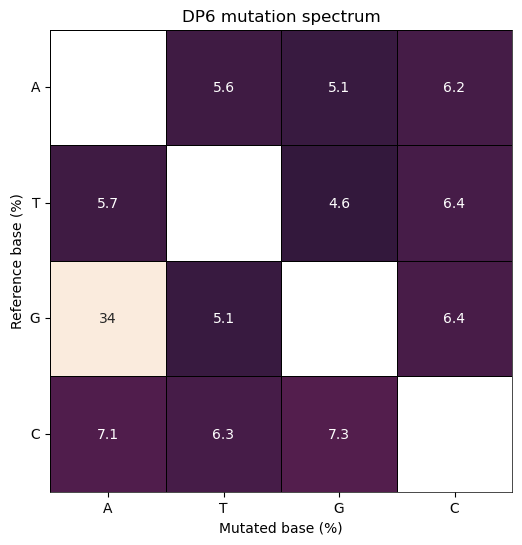

<Figure size 640x480 with 0 Axes>

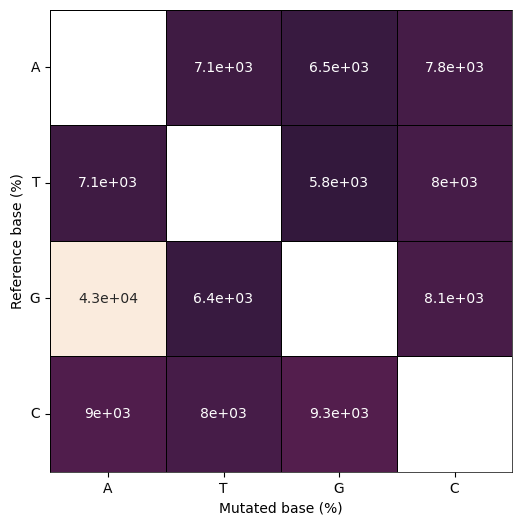

In [497]:
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(DP6_n_mut_spectrum_perc_df, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black")
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
plt.title("DP6 mutation spectrum", fontsize = 12)
plt.show()
plt.clf()


f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(DP6_n_mut_spectrum_df, annot=True, linewidths=.5, ax=ax, cbar = False, vmin = 0, square = True, linecolor = "black")
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
#ax.set_facecolor('gray')
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
plt.show()